In [66]:
# TODO: General feedback
#  - You're making good progress and are heading in the right direction.
#  - Justify your choices in Markdown cells. See the TODOs below.

In [67]:
import keras_tuner
import pandas as pd
import seaborn as sns
from keras_tuner.src.backend import keras
from scipy import stats
import joblib
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, r_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder

dataset = pd.read_csv('smartphone_cleaned_new.csv')

print("-------------------DATA PREPROCESSING---------------------")

dataset.info()
dataset.isnull().sum()

-------------------DATA PREPROCESSING---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand_name        980 non-null    object 
 1   model             980 non-null    object 
 2   price             980 non-null    int64  
 3   rating            879 non-null    float64
 4   has_5g            980 non-null    bool   
 5   has_nfc           980 non-null    bool   
 6   processor_brand   960 non-null    object 
 7   num_cores         974 non-null    float64
 8   processor_speed   938 non-null    float64
 9   battery_capacity  969 non-null    float64
 10  os                966 non-null    object 
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 70.9+ KB


brand_name            0
model                 0
price                 0
rating              101
has_5g                0
has_nfc               0
processor_brand      20
num_cores             6
processor_speed      42
battery_capacity     11
os                   14
dtype: int64

# The dataset contains 11 columns  with around 1000 rows. In this case our target variable will be the price column. In the dataset we have a mix of features with numerical and object values. What we are going to do is prepare this dataset for our needs and select the best features for our model.

# Missing values interfere when it comes to the accuracy of the model, so we need to handle them. We can either drop the rows with missing values or replace them with the mean or mode of the column. In this case I've replaced them with the mean or mode of the column. Since there are quite a lot of budget and high-end phones I've decided to replace the missing values with the mean or mode of the column grouped by the brand name. This way the values will be more accurate and the model will be able to make better predictions. I am also removing model since i won't be using it for my model.

In [68]:
# Feature Creation (adding the missing values instead of dropping them)
def remove_missing_values(df):
    for column in df.columns:
        if df[column].dtype == object:
            df[column] = df[column].fillna(df.groupby('brand_name')[column].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))
        else:
            df[column] = df[column].fillna(df.groupby('brand_name')[column].transform('mean'))
    df.dropna(inplace=True)
    return df



cleaned_dataset = remove_missing_values(dataset)

print(cleaned_dataset.isnull().sum())
print(cleaned_dataset.dtypes)

cleaned_dataset_copy = cleaned_dataset.copy()

# Convert to categorical data
cleaned_dataset_copy[['brand_name', 'model', 'processor_brand', 'os']] = cleaned_dataset_copy[
    ['brand_name', 'model', 'processor_brand', 'os']].astype('category')

cleaned_dataset_copy = cleaned_dataset_copy.drop(columns=['model'])

print(cleaned_dataset_copy.dtypes)


brand_name          0
model               0
price               0
rating              0
has_5g              0
has_nfc             0
processor_brand     0
num_cores           0
processor_speed     0
battery_capacity    0
os                  0
dtype: int64
brand_name           object
model                object
price                 int64
rating              float64
has_5g                 bool
has_nfc                bool
processor_brand      object
num_cores           float64
processor_speed     float64
battery_capacity    float64
os                   object
dtype: object
brand_name          category
price                  int64
rating               float64
has_5g                  bool
has_nfc                 bool
processor_brand     category
num_cores            float64
processor_speed      float64
battery_capacity     float64
os                  category
dtype: object


# Here I wanted to check the distribution of the data for feature and target selecting purposes.

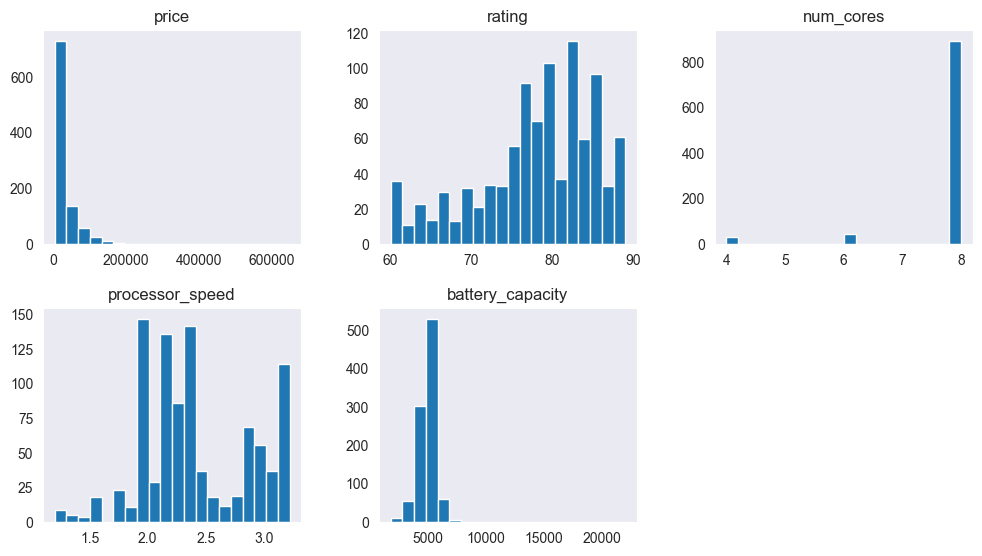

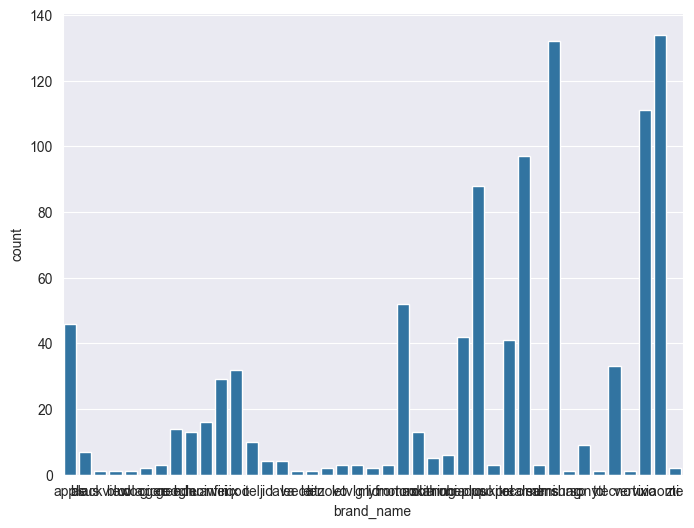

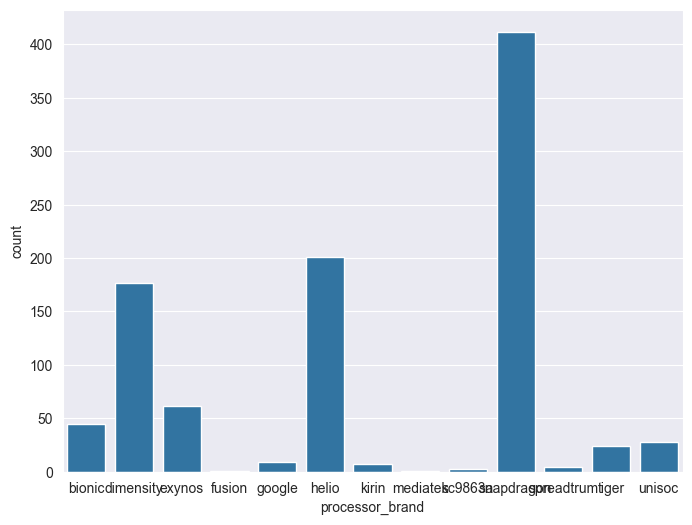

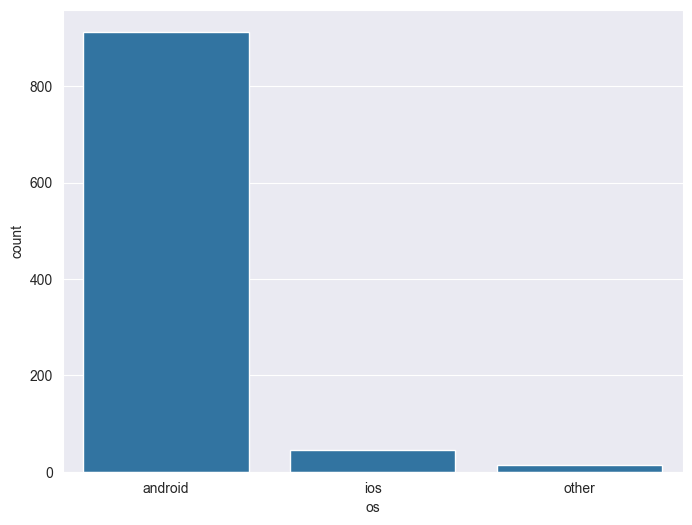

In [69]:
# Display histograms for numerical variables
numerical_columns = cleaned_dataset_copy.select_dtypes(include=['number']).columns
cleaned_dataset_copy[numerical_columns].hist(bins=20, figsize=(12, 10), layout=(3, 3), grid=False)
plt.show()

# Display count plots for categorical variables
categorical_columns = cleaned_dataset_copy.select_dtypes(include=['category']).columns
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=cleaned_dataset_copy, x=col)
    plt.show()

# I am converting the categorical features because f-regression works only with numeric data. I've used one hot encoding because it is the most suitable for my use case. It creates a new column for each category and assigns a 1 or 0 value to the column. I've abstained from doing any further outlier removal since the dataset was already properly cleaned and the outliers were already removed. Also considering the smartphones I have in the dataset compared to all the budget androids the price of the iphone might be considered an outlier, but it is not since it is a high-end phone.

In [70]:
# Convert categorical data to numerical data
# One-hot encoding for specified categorical columns
categorical_columns_to_encode = ['brand_name', 'processor_brand', 'os']
cleaned_dataset_copy = pd.get_dummies(cleaned_dataset_copy, columns=categorical_columns_to_encode)

# Remove outliers
# z_scores = np.abs(stats.zscore(cleaned_dataset_copy['price']))
# cleaned_dataset_copy = cleaned_dataset_copy[(z_scores < 2)]

print(cleaned_dataset_copy.shape)

#Save to csv
cleaned_dataset_copy.to_csv('cleaned_dataset_copy.csv', index=False)

cleaned_dataset_copy.head()

(972, 64)


,price,rating,has_5g,has_nfc,num_cores,processor_speed,battery_capacity,brand_name_apple,brand_name_asus,brand_name_blackview,...,processor_brand_kirin,processor_brand_mediatek,processor_brand_sc9863a,processor_brand_snapdragon,processor_brand_spreadtrum,processor_brand_tiger,processor_brand_unisoc,os_android,os_ios,os_other
0,54999,89.0,True,True,8.0,3.2,5000.0,False,False,False,...,False,False,False,True,False,False,False,True,False,False
1,19989,81.0,True,False,8.0,2.2,5000.0,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,16499,75.0,True,False,8.0,2.4,5000.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,14999,81.0,True,False,8.0,2.2,5000.0,False,False,False,...,False,False,False,True,False,False,False,True,False,False
4,24999,82.0,True,False,8.0,2.6,5000.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


# In order to select the best features for my model I am going to use the SelectKBest function. It includes several test that can help you determine the best features for your use case. In this case I am going to use the f_regression. It is a linear model for testing the effect of a single regressor, sequentially for many regressors. f_regression is derived from r_regression and will rank features in the same order if all the features are positively correlated with the target.

In [71]:
# Feature Selection
# Exclude the target variable from input features
X = cleaned_dataset_copy.drop(columns=['price'])
y = cleaned_dataset_copy['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=4)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
best_features = selector.get_support(indices=True)

# Display the selected feature names
selected_feature_names = X.columns[best_features].tolist()
print("Selected Features:", selected_feature_names)

Selected Features: ['has_nfc', 'processor_speed', 'processor_brand_bionic', 'os_android']


# I've split the dataset into training and test sets because I need to train the model on the training set and then test it on the test set. This way I can see how well the model performs on unseen data. I've used the train_test_split function to split the dataset into training and test sets. The other way to do it is to use cross-validation.

In [72]:
X = cleaned_dataset_copy[['has_nfc', 'processor_speed', 'os_android', 'processor_brand_bionic']]
y = cleaned_dataset_copy['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# The first model I've used is the Linear Regression model. It is a supervised machine learning algorithm that is used to predict the value of a variable based on the value of another variable. It is a linear model which means that it assumes a linear relationship between the input variables (X) and the single output variable (y). It is also a regression algorithm which means that it is used for predicting a continuous variable. I've used it because it is a simple model and it is a good starting point for my use case.

In [73]:
model_lnn = LinearRegression()
model_lnn.fit(X_train, y_train)

predictions_lnn = model_lnn.predict(X_test)

joblib.dump(model_lnn, 'model_lnn.pkl')


r_squared = r2_score(y_test, predictions_lnn)

print(f'R-squared: {r_squared:.2f}')

R-squared: 0.61


# The second model I've used is the Decision Tree model. It is a supervised machine learning algorithm that is used for classification and regression problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome. It is a non-parametric model which means that it doesn't make any assumptions on the underlying data distribution.

In [74]:
print("-------------------DECISION TREE---------------------")
# DECISION TREE CLASSIFIER MODEL

# Create, train model and make some predictions
model_decision_tree = DecisionTreeRegressor()
model_decision_tree.fit(X_train, y_train)

# joblib.dump(model_decision_tree, 'model_decision_tree.pkl')

predictions = model_decision_tree.predict(X_test)

# Evaluate the model

r_squared = r2_score(y_test, predictions)

print(f'R-squared: {r_squared:.2f}')


-------------------DECISION TREE---------------------
R-squared: 0.58


# The third model I've used is the Random Forest model. It is the better version of the Decision Tree model because instead of one tree it uses a bunch of them.

In [75]:
from sklearn.ensemble import RandomForestRegressor

print("-------------------RANDOM FOREST---------------------")
# RANDOM FOREST CLASSIFIER MODEL
model_random_forest = RandomForestRegressor()
model_random_forest.fit(X_train, y_train)

# joblib.dump(model_random_forest, 'model_random_forest.pkl')

predictions_random_forest = model_random_forest.predict(X_test)


r_squared = r2_score(y_test, predictions_random_forest)

print(f'R-squared: {r_squared:.2f}')


-------------------RANDOM FOREST---------------------
R-squared: 0.65


# I've used the KNeighboursRegressor model because it is pretty similar to the decision tree and random forest but unlike them, it is also a lazy learning algorithm which means that it doesn't learn a discriminative function from the training data but memorizes the training dataset instead. 

In [76]:
# KNN CLASSIFIER MODEL

model_knn = KNeighborsRegressor()
model_knn.fit(X_train, y_train)

joblib.dump(model_knn, 'model_knn.pkl')

predictions_knn = model_knn.predict(X_test)

# Evaluate the model


r_squared = r2_score(y_test, predictions_knn)

print(f'R-squared: {r_squared:.2f}')


R-squared: 0.65


# Lasso and Ridge I chose simply because they are the most popular linear regression models. They are both linear models that use a regularization term to prevent overfitting. The difference between them is that Lasso uses L1 regularization and Ridge uses L2 regularization. Lasso is used for feature selection because it can shrink the coefficients of less important features to zero. Ridge is used to prevent overfitting. So I was curious to see how they perform compared to the other models.

In [77]:
model_lasso = Lasso()
model_lasso.fit(X_train, y_train)

predictions_lasso = model_lasso.predict(X_test)

joblib.dump(model_lasso, 'model_lasso.pkl')


r_squared = r2_score(y_test, predictions_lasso)

print(f'R-squared: {r_squared:.2f}')

R-squared: 0.61


In [78]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

predictions_ridge = model_ridge.predict(X_test)

joblib.dump(model_ridge, 'model_ridge.pkl')


r_squared = r2_score(y_test, predictions_ridge)

print(f'R-squared: {r_squared:.2f}')

R-squared: 0.61


# I decided to implement cross-validation since it's a more robust method than a single train-test split like above. By performing the split once you might get a test set that is too easy or too complicated for my model. Cross-validation addresses this issue by performing multiple splits (5 in my case) and averaging the results. So I thought it might be more fitting for my use case.

In [79]:
# Define your models
models = {
    'Linear Regression': model_lnn,
    'Decision Tree': model_decision_tree,
    'Random Forest': model_random_forest,
    'KNN': model_knn,
    'Lasso': model_lasso,
    'Ridge': model_ridge
}

# Perform cross-validation and print results for each model
for model_name, model in models.items():
    # Use negative mean squared error (neg_mean_squared_error) for scoring
    mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Calculate R-squared scores separately
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Print results
    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE) Scores: {mse_scores}")
    print(f"R-squared Scores: {r2_scores}")
    print(f"Mean R-squared: {r2_scores.mean()}")
    print("\n")


Model: Linear Regression
Mean Squared Error (MSE) Scores: [-6.44509851e+08 -2.87480594e+09 -1.55097392e+09 -3.51226919e+08
 -6.94958296e+08]
R-squared Scores: [0.52280943 0.04256504 0.29745677 0.41888189 0.40406912]
Mean R-squared: 0.33715644978005777


Model: Decision Tree
Mean Squared Error (MSE) Scores: [-7.81092472e+08 -3.04941646e+09 -1.74987408e+09 -4.30472382e+08
 -9.49017019e+08]
R-squared Scores: [ 0.42168461 -0.01558783  0.20736115  0.2877673   0.18621225]
Mean R-squared: 0.2174874968887294

Model: Random Forest
Mean Squared Error (MSE) Scores: [-6.64569343e+08 -2.96402046e+09 -1.69751889e+09 -4.10982453e+08
 -8.62013020e+08]
R-squared Scores: [0.52020483 0.01699879 0.22488286 0.33493078 0.29925475]
Mean R-squared: 0.27925439933321056


Model: KNN
Mean Squared Error (MSE) Scores: [-6.25027613e+08 -2.83913550e+09 -1.67067525e+09 -4.13582717e+08
 -7.18723544e+08]
R-squared Scores: [0.53723394 0.05444484 0.24323577 0.31571188 0.38369028]
Mean R-squared: 0.3068633436110587


Mode

# After a few runs I've noticed the linear models work the best in my case. Sometimes the KNR model gives a high score as well, but it's not consistent. Ridge and Lasso also give good results but not as good as the linear regression model. The decision tree and random forest models are not suitable for my use case because they are not able to predict the price of a smartphone with a high degree of accuracy. Hence, why I've decided to use the linear regression model for my final part which is the hypertuning so we can see if we can make it even better. 